In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import gc

from astropy.visualization import astropy_mpl_style
from astropy.io import fits
from skimage.transform import resize


# ФОРМУЛА ИЗ ДОКУМЕНТА МАТВЕЯ
# ...
# Подынтегральные функции
def pod_integrant_main(fx, fy, z, lambda_, delta):
    def aperture_func(fx, fy, delta): # A(-f)
        res = np.abs(np.sinc(delta*(-fx))*np.sinc(delta*(-fy)))**2
        return res
    
    def a1(fx, fy): # |f|^(-11/3)
        res = pow(np.sqrt(fx**2+fy**2), -11./3.)
        return res

    def a2(fx, fy, z, lambda_): # sin^2(pi*z*lambda*|f|^2)/lambda^2
        res = pow(np.sin(np.pi*z*lambda_*(fx**2+fy**2)), 2) / pow(lambda_, 2)
        return res

    def a1_with_a2(fx, fy, z, lambda_):
        res = a1(fx, fy) * a2(fx, fy, z, lambda_)
        res[np.isnan(res)] = 0
        return res
    
    return a1_with_a2(fx, fy, z, lambda_) * aperture_func(fx, fy, delta)

# c_jk
def c(data, nx):
    img = data[0]
    data_pupil = np.pad(img, ((228 - img.shape[0], 0), (0, 228 - img.shape[1])), 'constant', constant_values=(0))
    I0c = (data_pupil != 0) * int(1)
    I0c = np.pad(I0c, ((nx - I0c.shape[0])//2, (nx - I0c.shape[1])//2), 'constant', constant_values=(0))
    c_jk = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
    c_jk /= np.max(c_jk)
#     print('подсчет кол-ва пикселей, где I0c = 1:', np.sum(I0c == 1)) # центральное значение на автокорреляции = кол-во освещенных пикселей
#     print('max c_jk values:', np.unravel_index(np.argmax(c_jk), c_jk.shape), np.max(c_jk))
    return c_jk
    

# Константа перед интегралом 
const = 9.69*pow(10, -3)*16*pow(np.pi, 2) 

# gamma
# def gamma(C, const, data, nx, f_scale):
#     ft = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(pod_integrant_main(xx_scale, yy_scale, z, lambda_, delta)))))
    


# ПОЛУЧЕНИЕ ЗРАЧКА И КОРРЕЛЯЦИЯ
# ...
# Корреляция
def correlate(data, latency):
    correlation = np.zeros_like(data)
    def correlate_fft(img1, img2):
        corr = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(img1)*np.fft.fft2(img2).conjugate()))) # np.real <-> np.abs
        corr /= np.max(corr)
        return corr
    
    for i in range(data.shape[0] - latency):
        correlation[i] = correlate_fft(data[i], data[i + latency])
    
    return np.mean(correlation, axis=0)
    
# Получение обрезанного изображения зрачка 
def pupil(data):
    def avr_data(data):
        return np.mean(data, axis=0)
    
    def norm_data(data):
        return (data)/(avr_data(data)) - 1
    
    def otsu_tresh(image_gray):
        mean_weight = 1 / image_gray.size
        his, bins = np.histogram(image_gray, np.arange(0,257))
        final_thresh = -1
        final_value = -1
        intensity_arr = np.arange(256)
        np.seterr(invalid='ignore')
        for t in bins[0:-1]: 
            pcb = np.sum(his[:t])
            pcf = np.sum(his[t:])   
            Wb = pcb * mean_weight
            Wf = pcf * mean_weight
            mub = np.sum(intensity_arr[:t]*his[:t]) / np.float32(pcb)
            muf = np.sum(intensity_arr[t:]*his[t:]) / np.float32(pcf)
            value = Wb * Wf * (mub - muf) ** 2
            if value > final_value:
                final_thresh = t
                final_value = value
        return final_thresh
    
    def im_bin(data):
        return (avr_data(data) > otsu_tresh(avr_data(data))) * int(255)

    def otsu_res(data):
        return norm_data(data) * im_bin(data)

    def sq_cropp(data):
        mask = otsu_res(data)[0] != 0
        rows = np.flatnonzero((mask.any(axis=1))) 
        cols = np.flatnonzero((mask.any(axis=0)))
        squared = otsu_res(data)[:, rows.min():rows.max()+1, cols.min():cols.max()+1] 
        return squared 
    
    return sq_cropp(data)   

# Отрисовка скорости ветра и турбулентных пятен
def draw_correlate_with_velocity(data, D, latency, frames_per_sec):
    def v(D, img, latency, frames_per_sec):
        return (D / img.shape[1]) / (latency * frames_per_sec)
    
    def cross_corr_with_velocity(data, D, latency, frames_per_sec): 
        img = data.copy()
        x = np.round(v(D, img, latency, frames_per_sec)*np.linspace(-img.shape[0]//2, img.shape[0]//2, 5), 2)
        fig = plt.figure()
        ax = plt.axes()
        im = plt.imshow(img)
        ax.set_xticks(np.linspace(0, img.shape[1], 5))
        ax.set_yticks(np.linspace(0, img.shape[0], 5))
        ax.set_xticklabels(x, fontsize=12)
        ax.set_yticklabels(x, fontsize=12)
        ax.set_ylabel('Vy, m/s', fontsize=12)
        ax.set_xlabel('Vx, m/s', fontsize=12)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(im, cax=cax)
        ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

Filename: C:\Users\miron\coding\DomecamDraft\bias20210130.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 1000)   int16 (rescales to uint16)   
Filename: C:\Users\miron\coding\DomecamDraft\20210130l_m2km.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 6000)   int16 (rescales to uint16)   
 
time: 167.4817782


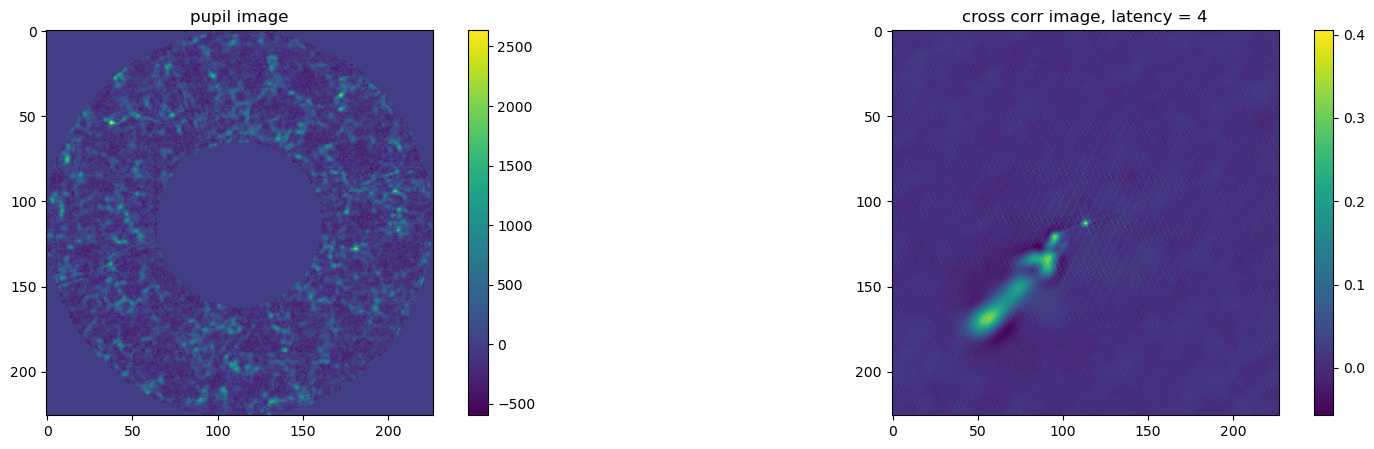

In [2]:
# MAIN
file = '20210130l_m2km.fits'
file_bias = 'bias20210130.fits'
D = 2.5 # диаметр телескопа, [м]
lambda_ = 500*pow(10, -9) # длина волны, [м]
z = 2000 # дистанция распространения, [м].
latency = 4 # задержка в кросс-корреляции
# С увеличением z амплитуда дистанции распространения будет увеличиваться, из ща этого увеличиться и индекс мерцания


st = time.perf_counter()
with fits.open(os.path.abspath(file_bias)) as fb:
    fb.info()
    bias = np.mean(fb[0].data.astype(np.float32), axis=0)
    
with fits.open(os.path.abspath(file)) as f:
    f.info()
    frames_per_sec = 1 / f[0].header['FRATE']
    data = pupil(f[0].data.astype(np.float32) - bias)
    data_corr = correlate(data, latency)
    

fig, (ax_img, ax_img2) = plt.subplots(1, 2, figsize=(20, 5))

ax_img.imshow(data[0])
fig.colorbar(ax_img.imshow(data[0]), ax = ax_img)
ax_img.set_title('pupil image')

ax_img2.imshow(data_corr)
fig.colorbar(ax_img2.imshow(data_corr), ax = ax_img2)
ax_img2.set_title(f'cross corr image, latency = {latency}')

gc.collect()
print(' ')
print('time:', time.perf_counter()-st)

In [3]:
'''
Ex:

Для примера пусть Cn2 соответствует качеству изображения, равному 1 угловой секунде (типичное качество изображения) на длине 
волны 500 нм. Для удобства величину Cn2(z)dz рассматриваем как одну величину, обозначим ее C. Тогда:
    beta = 0.98 * lambda/r0 = 1, следовательно: r0 = 0.98*lambda*206265,
Пусть мы наблюдаем в зените, тогда параметр Фрида будет:
    r0 = (0.423*k^2 * C)^(-3/5), где k = 2*pi/lambda.
Далее можно просто выразить и посчитать С


    beta = 0.98 * lambda / r0 
    r0 = (0.423 * k^2 * C)^(-3/5) 
    beta = 0.98 * lambda / (0.423 * k^2 * C)^(-3/5) 
'''
Cn2_ex = pow((0.98*lambda_)*206265, -5/3) / (0.423*pow(2*np.pi/lambda_, 2))
print('example Cn2:', Cn2_ex, 'beta', 1)
Ctmp = pow(10, -14)

print('answer:', (0.98*lambda_*206265) / (pow(0.423 * pow(2*np.pi/lambda_, 2) * Ctmp, -3/5)), 'Ctmp', pow(10, -14))

example Cn2: 6.826590771729513e-13 beta 1
answer: 0.07933734784206645 Ctmp 1e-14


In [5]:
# диаметр телескопа в пикселях
D_pix = 228

# кол-во пикселей. для отображения полного результата c_jk кол-во пикселей должно быть как минимум в два раза больше, чем на 
# исходном изображении-зрачке
nx = 512 

# шаг по частоте, [м^-1]
f_scale = D_pix/(D*nx) 

# шаг апертуры (соотношение между 1 пикселем и метрами, т.е. 1 пикс = 0.01 м) 
delta = 0.01 

xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
xx_scale = f_scale * xx 
yy_scale = f_scale * yy

# подсчет интеграла
ft = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(pod_integrant_main(xx_scale, yy_scale, z, lambda_, delta)))))
                                                                             
# подсчет гаммы                                                                             
gamma = Cn2_ex * const * c(data, nx) * ft * pow(f_scale, 2) * nx * nx

# коэфф домножения = отношение реальной гаммы и искуственной в центре изображения
k = np.max(data_corr[104:124, 104:124]) / np.max(gamma)

# реальное значение Cn2 на дистанции распространения z
Cn2 = Cn2_ex * k

# пересчет новой гаммы
gamma_new = Cn2 * const * c(data, nx) * ft * pow(f_scale, 2) * nx * nx

print(' ')
print('проверка на NaN:', np.count_nonzero(np.isnan(gamma)))
print('gamma shape:', gamma.shape)
print('max gamma value:', np.unravel_index(np.argmax(gamma), gamma.shape), np.max(gamma))
print('max data_corr value:', np.unravel_index(np.argmax(data_corr), data_corr.shape), np.max(data_corr))
print('коэфф домножения k:', k)
print('true Cn2 value:', Cn2)
print('max gamma_new value:', np.unravel_index(np.argmax(gamma_new), gamma_new.shape), np.max(gamma_new))

 
проверка на NaN: 0
gamma shape: (512, 512)
max gamma value: (256, 256) 0.13575001320735405
max data_corr value: (113, 113) 0.40518728847932745
коэфф домножения k: 2.984804781274062
true Cn2 value: 2.0376040775259637e-12
max gamma_new value: (256, 256) 0.40518728847932745


C:\Users\miron\AppData\Local\Temp\ipykernel_12780\2622717001.py:23: RuntimeWarning: divide by zero encountered in power
  res = pow(np.sqrt(fx**2+fy**2), -11./3.)


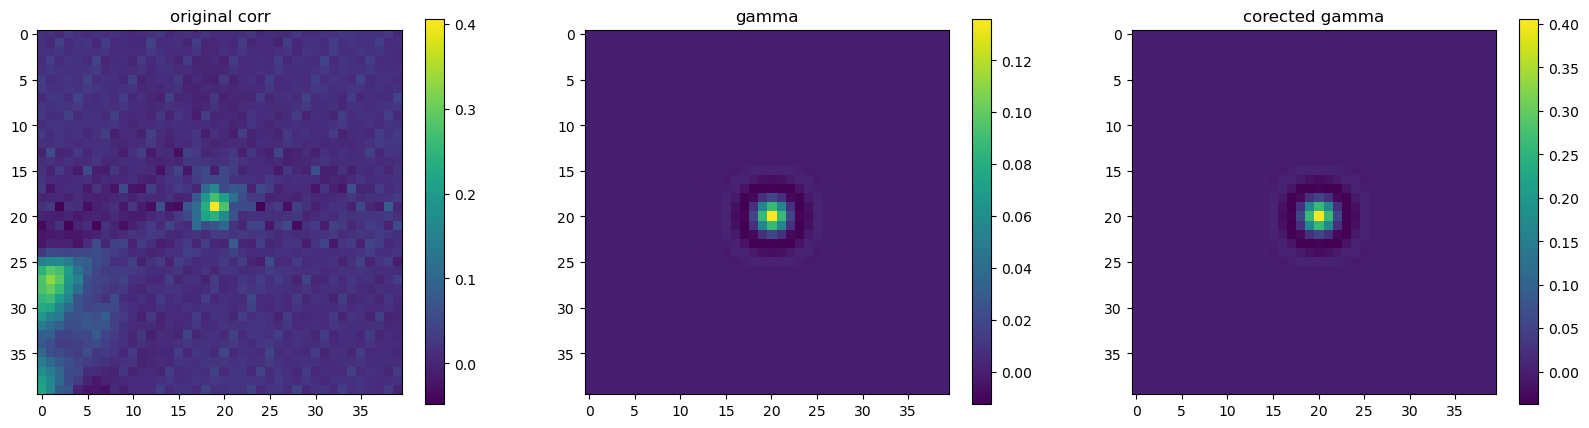

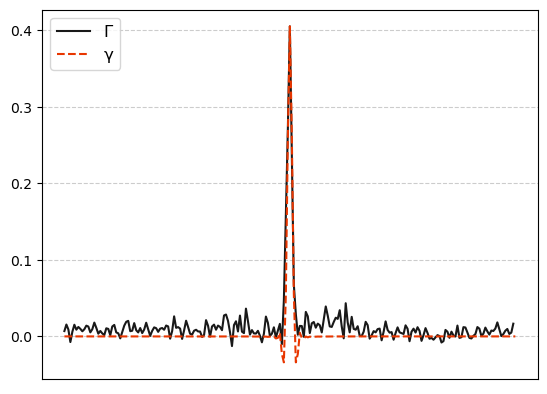

In [22]:
# Отрисовка
Y = data_corr[:, 113]
X = range(226)
Y2 = gamma[143:370, 256]
X2 = range(227)
Y3 = gamma_new[143:370, 256]
X3 = range(227)

fig, (ax_img, ax_img3, ax_img4) = plt.subplots(1, 3, figsize=(20, 5))

fig.colorbar(ax_img.imshow(data_corr[94:134, 94:134]), ax = ax_img)
ax_img.set_title('original corr')

fig.colorbar(ax_img3.imshow(gamma[236:276, 236:276]), ax = ax_img3)
ax_img3.set_title('gamma')

fig.colorbar(ax_img4.imshow(gamma_new[236:276, 236:276]), ax = ax_img4)
ax_img4.set_title('corected gamma')


plt.figure()
plt.plot(X, Y, alpha = 0.9, label = 'original corr', color = '#000000')
# plt.plot(X2, Y2, alpha = 0.7, label = 'gamma', color = 'red')
plt.plot(X3, Y3, alpha = 1, ls = '--', label = 'corected gamma', color = '#e83600')
plt.legend(['Γ', 'γ'], loc=2, prop={'size': 12})
plt.xticks([])
plt.grid(color = 'black', linestyle='--', alpha = 0.2)
# plt.title('срез по центральному Х')
plt.savefig('C:/astro/teor_corr.png', bbox_inches='tight')

In [7]:
def aperture_func(fx, fy, delta): # A(-f)
    res = np.abs(np.sinc(delta*(-fx))*np.sinc(delta*(-fy)))**2
    return res
    
def a1(fx, fy): # |f|^(-11/3)
    res = pow(np.sqrt(fx**2+fy**2), -11./3.)
    return res


def F(): # F(lambda)   

def S(fx, fy, z, lambda_):
    integrl = F(lambda_)/lambda_ * np.exp(np.pi*np.complex(0,1)*lambda_*z*(fx**2+fy**2))
    return pow(np.imag(np.fft.fft2(integrl)))

def integrl_main(fx, fy, delta, z):
    return a1(fx, fy)*aperture_func(fx, fy, delta)*S(fx, fy, z)


ft_poly = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(integrl_main(fx, fy, delta, z)))))


gamma_poly = Cn2_ex * const * c(data, nx) * ft_poly * pow(f_scale, 2) * nx * nx

SyntaxError: invalid syntax (3973164323.py, line 2)

In [ ]:
'''
data_test = data
print('data test shape:', data_test.shape)
st = time.perf_counter()

data_resized = resize(data_test, (data_test.shape[0], data_test.shape[1] // 3, data_test.shape[2] // 3), anti_aliasing=False)
data_avr_corr = cross_corr(data_resized, 4) 

kern = np.array([[ -1, -2, -1],
                 [ -2, 22, -2],
                 [ -1, -2, -1]])
data_box_filter = cvf.box_filter(data_avr_corr, kern)
data_resized_back = resize(data_box_filter, (data_test.shape[1], data_test.shape[2]), anti_aliasing=False)
# data_resized_back = resize(data_avr_corr, (data_test.shape[1], data_test.shape[2]), anti_aliasing=False)



print('time:', time.perf_counter() - st)

print('data resized back shape:', data_resized_back.shape)
draw_corr_with_velocity(data_resized_back, 2.5, 4, frames_per_sec)

data_uint = img_as_ubyte(data_resized_back)
print('otsu tresh:', otsu_tresh(data_uint))
data_otsu = (data_uint > otsu_tresh(data_uint)) * int(255)
fig = plt.figure()
ax = plt.axes()
im = plt.imshow(data_otsu)

# window = np.ones((7, 7))
# data_median = cvf.median_filter(data_otsu, window)
# fig = plt.figure()
# ax = plt.axes()
# im = plt.imshow(data_median)

del data_test
'''